# An Introduction to `repro_eval`

### Imports

Once installed, the Evaluator classes for the evaluation of reproducibility and replicability can be imported. In this notebook, we also include other Python packages that are not necessarily required when using `repro_eval` for your experiments.

In [1]:
from repro_eval.Evaluator import RpdEvaluator, RplEvaluator
from repro_eval.util import arp, arp_scores
from repro_eval.util import print_base_adv, print_simple_line
from repro_eval.util import trim

import pytrec_eval
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
colors = sns.color_palette()

### Path definition
You can modify these paths and adapt them to your experiments. The entire notebook should be usable with your experiments when they comply with the given evaluation scenario. First, we need two kind of runs - a baseline run and an advanced run (that outperforms the baseline run). Second, for the evaluation of replicability, the replicated runs should be derived from another target collection. The dictionaries `runs_rpd` and `runs_rpl` contain runs with different parametrizations, but it should also be possible to include just one version for both the baseline and advanced run.

In [2]:
QREL = './data/qrels/core17.txt'
QREL_RPL = './data/qrels/core18.txt'
ORIG_B = './data/runs/orig/input.WCrobust04'
ORIG_A = './data/runs/orig/input.WCrobust0405'
RPD_B = './data/runs/rpd/14/irc_task1_WCrobust04_001'
RPD_A = './data/runs/rpd/14/irc_task1_WCrobust0405_001'
RPL_B = './data/runs/rpl/14/irc_task2_WCrobust04_001'
RPL_A = './data/runs/rpl/14/irc_task2_WCrobust0405_001'
MEASURE = 'ndcg'

runs_rpd = {
    'rpd_wcr04_tf_1':
        {'path': './data/runs/rpd/45/irc_task1_WCrobust04_001'},
    'rpd_wcr0405_tf_1':
        {'path': './data/runs/rpd/45/irc_task1_WCrobust0405_001'},
    'rpd_wcr04_tf_2':
        {'path': './data/runs/rpd/46/irc_task1_WCrobust04_001'},
    'rpd_wcr0405_tf_2':
        {'path': './data/runs/rpd/46/irc_task1_WCrobust0405_001'},
    'rpd_wcr04_tf_3':
        {'path': './data/runs/rpd/47/irc_task1_WCrobust04_001'},
    'rpd_wcr0405_tf_3':
        {'path': './data/runs/rpd/47/irc_task1_WCrobust0405_001'},
    'rpd_wcr04_tf_4':
        {'path': './data/runs/rpd/48/irc_task1_WCrobust04_001'},
    'rpd_wcr0405_tf_4':
        {'path': './data/runs/rpd/48/irc_task1_WCrobust0405_001'},
    'rpd_wcr04_tf_5':
        {'path': './data/runs/rpd/49/irc_task1_WCrobust04_001'},
    'rpd_wcr0405_tf_5':
        {'path': './data/runs/rpd/49/irc_task1_WCrobust0405_001'}
}

runs_rpl = {
    'rpl_wcr04_tf_1':
        {'path': './data/runs/rpl/45/irc_task2_WCrobust04_001'},
    'rpl_wcr0405_tf_1':
        {'path': './data/runs/rpl/45/irc_task2_WCrobust0405_001'},
    'rpl_wcr04_tf_2':
        {'path': './data/runs/rpl/46/irc_task2_WCrobust04_001'},
    'rpl_wcr0405_tf_2':
        {'path': './data/runs/rpl/46/irc_task2_WCrobust0405_001'},
    'rpl_wcr04_tf_3':
        {'path': './data/runs/rpl/47/irc_task2_WCrobust04_001'},
    'rpl_wcr0405_tf_3':
        {'path': './data/runs/rpl/47/irc_task2_WCrobust0405_001'},
    'rpl_wcr04_tf_4':
        {'path': './data/runs/rpl/48/irc_task2_WCrobust04_001'},
    'rpl_wcr0405_tf_4':
        {'path': './data/runs/rpl/48/irc_task2_WCrobust0405_001'},
    'rpl_wcr04_tf_5':
        {'path': './data/runs/rpl/49/irc_task2_WCrobust04_001'},
    'rpl_wcr0405_tf_5':
        {'path': './data/runs/rpl/49/irc_task2_WCrobust0405_001'}
}

Define a helping function for plotting the average retrieval performance (ARP) later in the notebook.

In [3]:
def average_retrieval_performance(baseline_scores, reproduced_scores: dict, measures: list, xlabel: str, ylabel: str):
    reproduced_scores_arp = [arp_scores(topic_scores) for idx, topic_scores in reproduced_scores.items()]
    baseline_scores_arp = arp_scores(baseline_scores)
    index = list(reproduced_scores.keys())
    df_content = {}
    for measure in measures:
        df_content[measure] = [scores.get(measure) for scores in reproduced_scores_arp]
    df = pd.DataFrame(df_content, index=index)

    plt.figure()
    ax = df.plot.bar(rot=0)
    for num, measure in enumerate(measures):
        orig_val = baseline_scores_arp.get(measure)
        ax.hlines(orig_val, -.5, 5.5, linestyles='dashed', color=colors[num])
        ax.annotate(' ', (num, orig_val), color=colors[num])
        ax.set_ylim(0.0, 1.0)

    legend_content = [measure + ' (orig)' for measure in measures] + [measure + ' (rpl)' for measure in measures]
    ax.legend(legend_content, loc='lower left')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

### Evaluating Reproducibility
The following code snippet instantiates a reproducibility evaluator `RpdEvaluator` and determines Kendall's tau Union (KTU), the Rank-biased Overlap (RBO), the Root-Mean-Square-Error (RMSE), the Effect Ratio (ER), the Delta Relative Improvement (DRI) and the p-values of the paired t-test.

In [4]:
rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=RPD_B,
                        run_a_rep_path=RPD_A)

rpd_eval.trim()
rpd_eval.evaluate()

# KTU
ktau = rpd_eval.ktau_union()
print("Kendall's tau Union (KTU)")
print('------------------------------------------------------------------')
for topic, value in ktau.get('baseline').items():
    print_base_adv(topic, 'KTU', value, ktau.get('advanced').get(topic))
print_base_adv('ARP', 'KTU', arp(ktau.get('baseline')), arp(ktau.get('advanced')))

# RBO
rbo = rpd_eval.rbo()
print("Rank-biased Overlap (RBO)")
print('------------------------------------------------------------------')
for topic, value in rbo.get('baseline').items():
    print_base_adv(topic, 'RBO', value, rbo.get('advanced').get(topic))
print_base_adv('ARP', 'RBO', arp(rbo.get('baseline')), arp(rbo.get('advanced')))

# RMSE
rmse = rpd_eval.rmse()
print("Root mean square error (RMSE)")
print('------------------------------------------------------------------')
for measure, value in rmse.get('baseline').items():
    print_base_adv(measure, 'RMSE', value, rmse.get('advanced').get(measure))

# ER
print("Effect ratio (ER)")
print('------------------------------------------------------------------')
er = rpd_eval.er()
for measure, value in er.items():
    print_simple_line(measure, 'ER', value)

# DRI
print("Delta Relative Improvement (DRI)")
print('------------------------------------------------------------------')
dri = rpd_eval.dri()
for measure, value in dri.items():
    print_simple_line(measure, 'DRI', value)

# ttest
pvals = rpd_eval.ttest()
print("Two-tailed paired t-test (p-value)")
print('------------------------------------------------------------------')
for measure, value in pvals.get('baseline').items():
    print_base_adv(measure, 'PVAL', value, pvals.get('advanced').get(measure))

Kendall's tau Union (KTU)
------------------------------------------------------------------
416                      KTU     BASE    -0.0421   ADV     -0.0273
336                      KTU     BASE    0.0218    ADV     0.0002
443                      KTU     BASE    0.0161    ADV     0.0242
620                      KTU     BASE    0.0117    ADV     0.0122
423                      KTU     BASE    0.0205    ADV     -0.0116
419                      KTU     BASE    0.0244    ADV     -0.0294
439                      KTU     BASE    -0.0169   ADV     -0.0090
345                      KTU     BASE    0.0274    ADV     0.0315
347                      KTU     BASE    -0.0121   ADV     -0.0133
677                      KTU     BASE    0.0254    ADV     0.0142
435                      KTU     BASE    0.0231    ADV     0.0138
408                      KTU     BASE    -0.0023   ADV     0.0124
307                      KTU     BASE    0.0161    ADV     0.0517
404                      KTU     BASE    0.0

### Comparing the Average Retrieval Performance (ARP) of different parametrizations 
The following code snippet determines the ARP scores and compares them via a bar plot.

<Figure size 432x288 with 0 Axes>

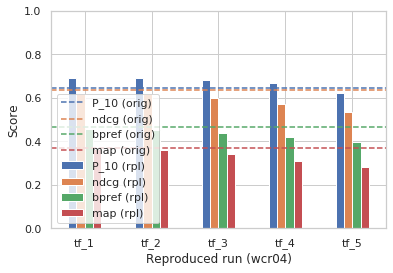

<Figure size 432x288 with 0 Axes>

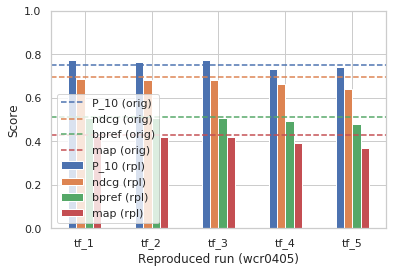

In [5]:
rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=None,
                        run_a_rep_path=None)

rpd_eval.trim()
rpd_eval.evaluate()

for run_name, info in runs_rpd.items():
    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        trim(info['run'])
        info['scores'] = rpd_eval.evaluate(info['run'])

average_retrieval_performance(rpd_eval.run_b_orig_score,
                              {
                                  'tf_1': runs_rpd.get('rpd_wcr04_tf_1').get('scores'),
                                  'tf_2': runs_rpd.get('rpd_wcr04_tf_2').get('scores'),
                                  'tf_3': runs_rpd.get('rpd_wcr04_tf_3').get('scores'),
                                  'tf_4': runs_rpd.get('rpd_wcr04_tf_4').get('scores'),
                                  'tf_5': runs_rpd.get('rpd_wcr04_tf_5').get('scores'),
                              },
                              measures=['P_10', 'ndcg', 'bpref', 'map'],
                              xlabel='Reproduced run (wcr04)',
                              ylabel='Score')

average_retrieval_performance(rpd_eval.run_a_orig_score,
                              {
                                  'tf_1': runs_rpd.get('rpd_wcr0405_tf_1').get('scores'),
                                  'tf_2': runs_rpd.get('rpd_wcr0405_tf_2').get('scores'),
                                  'tf_3': runs_rpd.get('rpd_wcr0405_tf_3').get('scores'),
                                  'tf_4': runs_rpd.get('rpd_wcr0405_tf_4').get('scores'),
                                  'tf_5': runs_rpd.get('rpd_wcr0405_tf_5').get('scores'),
                              },
                              measures=['P_10', 'ndcg', 'bpref', 'map'],
                              xlabel='Reproduced run (wcr0405)',
                              ylabel='Score')

### Kendall's tau Union (KTU) across different cut-offs
The following code snippet compares the ordering of documents for the reproduced runs across different cut-off ranks.

<Figure size 432x288 with 0 Axes>

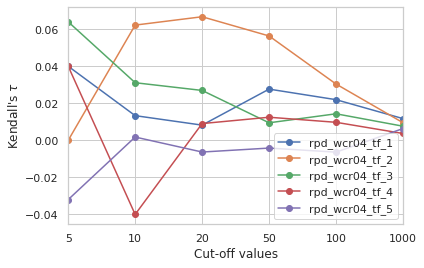

<Figure size 432x288 with 0 Axes>

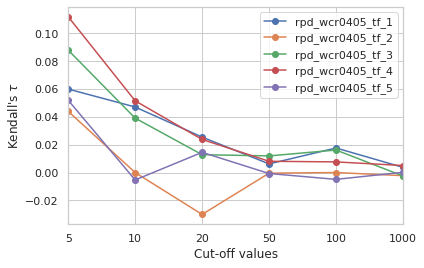

In [6]:
cutoffs = [1000, 100, 50, 20, 10, 5]

# BASELINE
for run_name, info in zip(list(runs_rpd.keys())[::2], list(runs_rpd.values())[::2]):
    rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                            run_b_orig_path=ORIG_B,
                            run_a_orig_path=ORIG_A,
                            run_b_rep_path=None,
                            run_a_rep_path=None)

    rpd_eval.trim()
    rpd_eval.evaluate()

    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        for cutoff in cutoffs:
            rpd_eval.trim(cutoff)
            rpd_eval.trim(cutoff, info['run'])
            info['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union(info['run'])['baseline'])

df_content = {}
for run_name, info in zip(list(runs_rpd.keys())[::2], list(runs_rpd.values())[::2]):
    df_content[run_name] = [info.get('ktu_' + str(cutoff)) for cutoff in cutoffs[::-1]]

plt.figure()
ax = pd.DataFrame(data=df_content, index=[str(cutoff) for cutoff in cutoffs[::-1]]).plot(style='o-')
ax.set_xlabel('Cut-off values')
ax.set_ylabel(r"Kendall's $\tau$")
plt.show()

# ADVANCED
for run_name, info in zip(list(runs_rpd.keys())[1::2], list(runs_rpd.values())[1::2]):
    rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                            run_b_orig_path=ORIG_B,
                            run_a_orig_path=ORIG_A,
                            run_b_rep_path=None,
                            run_a_rep_path=None)

    rpd_eval.trim()
    rpd_eval.evaluate()

    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        for cutoff in cutoffs:
            rpd_eval.trim(cutoff)
            rpd_eval.trim(cutoff, info['run'])
            # scores = rpl_eval.evaluate(info['run'])
            info['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union(info['run'])['baseline'])

df_content = {}
for run_name, info in zip(list(runs_rpd.keys())[1::2], list(runs_rpd.values())[1::2]):
    df_content[run_name] = [info.get('ktu_' + str(cutoff)) for cutoff in cutoffs[::-1]]

plt.figure()
ax = pd.DataFrame(data=df_content, index=[str(cutoff) for cutoff in cutoffs[::-1]]).plot(style='o-')
ax.set_xlabel('Cut-off values')
ax.set_ylabel(r"Kendall's $\tau$")
plt.show()

## Root-Mean-Square-Error (RMSE) across different cut-offs
The following code snippet compares the reproduced runs at the level of effectiveness by determining the RMSE across different cut-off ranks.

<Figure size 432x288 with 0 Axes>

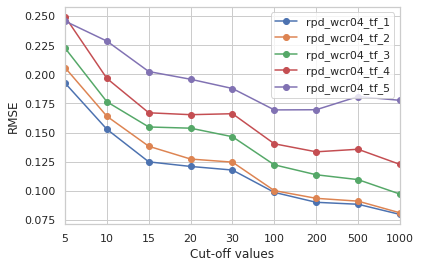

<Figure size 432x288 with 0 Axes>

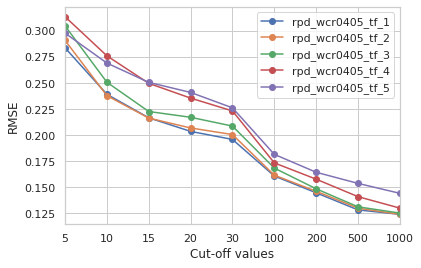

In [7]:
rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=None,
                        run_a_rep_path=None)

rpd_eval.trim()
rpd_eval.evaluate()

for run_name, info in runs_rpd.items():
    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        trim(info['run'])
        info['scores'] = rpd_eval.evaluate(info['run'])
        info['rmse'] = rpd_eval.rmse(run_b_score=info['scores'])


baseline_runs = ['rpd_wcr04_tf_1', 'rpd_wcr04_tf_2', 'rpd_wcr04_tf_3', 'rpd_wcr04_tf_4', 'rpd_wcr04_tf_5']
advanced_runs = ['rpd_wcr0405_tf_1', 'rpd_wcr0405_tf_2', 'rpd_wcr0405_tf_3', 'rpd_wcr0405_tf_4', 'rpd_wcr0405_tf_5']
cutoffs = ['5', '10', '15', '20', '30', '100', '200', '500', '1000']

df_content = {}
for run_name in baseline_runs:
    df_content[run_name] = [runs_rpd[run_name]['rmse']['baseline']['ndcg_cut_' + co] for co in cutoffs]

df = pd.DataFrame(df_content, index=cutoffs)
plt.figure()
ax = df.plot.line(style='o-')
ax.set_xlabel('Cut-off values')
ax.set_ylabel('RMSE')
plt.show()

df_content = {}
for run_name in advanced_runs:
    df_content[run_name] = [runs_rpd[run_name]['rmse']['baseline']['ndcg_cut_' + co] for co in cutoffs]

df = pd.DataFrame(df_content, index=cutoffs)
plt.figure()
ax = df.plot.line(style='o-')
ax.set_xlabel('Cut-off values')
ax.set_ylabel('RMSE')
plt.show()

## Exploring the space of reproducibility at the level of overall effects
The following code snippet plots the Delta Relative Improvement (DRI) against the Effect Ratio (ER). Having runs with different parametrizations at hand, we can compare them in the cartesian plane. As a rule of thumb, we can say the closer a point to (ER 1, DRI 0), the better the reproduction.

/home/breuert/anaconda3/lib/python3.7/site-packages/repro_eval/measure/overall_effects.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  yield measure, (mean - mean_scores_b.get(measure)) / mean_scores_b.get(measure)


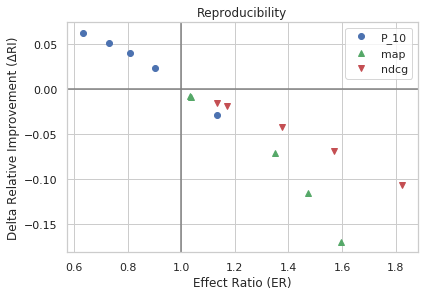

In [8]:
rpd_eval = RpdEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=None,
                        run_a_rep_path=None)

rpd_eval.trim()
rpd_eval.evaluate()

for run_name, info in runs_rpd.items():
    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        trim(info['run'])
        info['scores'] = rpd_eval.evaluate(info['run'])

dri_er = {
    'wcr_tf_1': {
        'er': rpd_eval.er(runs_rpd['rpd_wcr04_tf_1']['scores'], runs_rpd['rpd_wcr0405_tf_1']['scores']),
        'dri': rpd_eval.dri(runs_rpd['rpd_wcr04_tf_1']['scores'], runs_rpd['rpd_wcr0405_tf_1']['scores'])
    },
    'wcr_tf_2': {
        'er': rpd_eval.er(runs_rpd['rpd_wcr04_tf_2']['scores'], runs_rpd['rpd_wcr0405_tf_2']['scores']),
        'dri': rpd_eval.dri(runs_rpd['rpd_wcr04_tf_2']['scores'], runs_rpd['rpd_wcr0405_tf_2']['scores'])
    },
    'wcr_tf_3': {
        'er': rpd_eval.er(runs_rpd['rpd_wcr04_tf_3']['scores'], runs_rpd['rpd_wcr0405_tf_3']['scores']),
        'dri': rpd_eval.dri(runs_rpd['rpd_wcr04_tf_3']['scores'], runs_rpd['rpd_wcr0405_tf_3']['scores'])
    },
    'wcr_tf_4': {
        'er': rpd_eval.er(runs_rpd['rpd_wcr04_tf_4']['scores'], runs_rpd['rpd_wcr0405_tf_4']['scores']),
        'dri': rpd_eval.dri(runs_rpd['rpd_wcr04_tf_4']['scores'], runs_rpd['rpd_wcr0405_tf_4']['scores'])
    },
    'wcr_tf_5': {
        'er': rpd_eval.er(runs_rpd['rpd_wcr04_tf_5']['scores'], runs_rpd['rpd_wcr0405_tf_5']['scores']),
        'dri': rpd_eval.dri(runs_rpd['rpd_wcr04_tf_5']['scores'], runs_rpd['rpd_wcr0405_tf_5']['scores'])
    },

}

measures = ['P_10', 'map', 'ndcg']
marker_color = [('o', 'b'), ('^', 'g'), ('v', 'r')]

fig, ax1 = plt.subplots()
ax1.set_xlabel('Effect Ratio (ER)')
ax1.set_ylabel(u'Delta Relative Improvement (ΔRI)')

for measure, mk in zip(measures, marker_color):
    ax1.plot([dri_er[r]['er'][measure] for r in dri_er.keys()],
             [dri_er[r]['dri'][measure] for r in dri_er.keys()],
             marker=mk[0], color=mk[1], linestyle='None', label=measure)

ax1.tick_params(axis='y', labelcolor='k')
fig.tight_layout()
plt.axhline(0, color='grey')
plt.axvline(1, color='grey')
plt.legend()
plt.title('Reproducibility')
plt.show()

## Evaluating Replicability
The following code snippet instantiates a replicability evaluator `RplEvaluator` and determines the Effect Ratio (ER), the Delta Relative Improvement (DRI) and the p-values of the unpaired t-test.

In [9]:
rpl_eval = RplEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=RPL_B,
                        run_a_rep_path=RPL_A,
                        qrel_rpd_path=QREL_RPL)

rpl_eval.trim()
rpl_eval.evaluate()

# ER
print("Effect ratio (ER)")
print('------------------------------------------------------------------')
er = rpl_eval.er()
for measure, value in er.items():
    print_simple_line(measure, 'ER', value)

# DRI
print("Delta Relative Improvement (DRI)")
print('------------------------------------------------------------------')
dri = rpl_eval.dri()
for measure, value in dri.items():
    print_simple_line(measure, 'DRI', value)

# ttest
pvals = rpl_eval.ttest()
print("Two-tailed unpaired t-test (p-value)")
print('------------------------------------------------------------------')
for measure, value in pvals.get('baseline').items():
    print_base_adv(measure, 'PVAL', value, pvals.get('advanced').get(measure))

Effect ratio (ER)
------------------------------------------------------------------
map                      ER      0.7033
gm_map                   ER      1.4739
Rprec                    ER      1.0478
bpref                    ER      0.9327
recip_rank               ER      0.6801
iprec_at_recall_0.00     ER      1.1217
iprec_at_recall_0.10     ER      0.8901
iprec_at_recall_0.20     ER      0.6523
iprec_at_recall_0.30     ER      0.7361
iprec_at_recall_0.40     ER      0.7216
iprec_at_recall_0.50     ER      0.4080
iprec_at_recall_0.60     ER      0.5016
iprec_at_recall_0.70     ER      0.9840
iprec_at_recall_0.80     ER      0.9593
iprec_at_recall_0.90     ER      0.1212
iprec_at_recall_1.00     ER      1.2284
P_5                      ER      0.8696
P_10                     ER      0.4615
P_15                     ER      0.7042
P_20                     ER      0.5979
P_30                     ER      0.5816
P_100                    ER      0.4130
P_200                    ER      0.

## Exploring the space of replicability at the level of overall effects
The following code snippet plots the Delta Relative Improvement (DRI) against the Effect Ratio (ER). Having runs with different parametrizations at hand, we can compare them in the cartesian plane. As a rule of thumb, we can say the closer a point to (ER 1, DRI 0), the better the replication.

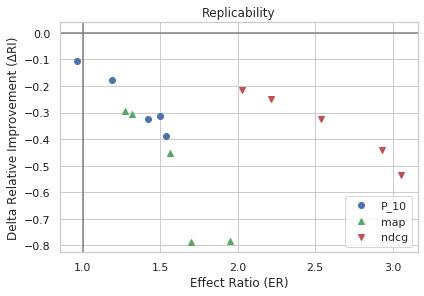

In [10]:
rpl_eval = RplEvaluator(qrel_orig_path=QREL,
                        run_b_orig_path=ORIG_B,
                        run_a_orig_path=ORIG_A,
                        run_b_rep_path=None,
                        run_a_rep_path=None,
                        qrel_rpd_path=QREL_RPL)

rpl_eval.trim()
rpl_eval.evaluate()

for run_name, info in runs_rpl.items():
    with open(info.get('path')) as run_file:
        info['run'] = pytrec_eval.parse_run(run_file)
        trim(info['run'])
        info['scores'] = rpl_eval.evaluate(info['run'])

dri_er = {
    'wcr_tf_1': {
        'er': rpl_eval.er(runs_rpl['rpl_wcr04_tf_1']['scores'], runs_rpl['rpl_wcr0405_tf_1']['scores']),
        'dri': rpl_eval.dri(runs_rpl['rpl_wcr04_tf_1']['scores'], runs_rpl['rpl_wcr0405_tf_1']['scores'])
    },
    'wcr_tf_2': {
        'er': rpl_eval.er(runs_rpl['rpl_wcr04_tf_2']['scores'], runs_rpl['rpl_wcr0405_tf_2']['scores']),
        'dri': rpl_eval.dri(runs_rpl['rpl_wcr04_tf_2']['scores'], runs_rpl['rpl_wcr0405_tf_2']['scores'])
    },
    'wcr_tf_3': {
        'er': rpl_eval.er(runs_rpl['rpl_wcr04_tf_3']['scores'], runs_rpl['rpl_wcr0405_tf_3']['scores']),
        'dri': rpl_eval.dri(runs_rpl['rpl_wcr04_tf_3']['scores'], runs_rpl['rpl_wcr0405_tf_3']['scores'])
    },
    'wcr_tf_4': {
        'er': rpl_eval.er(runs_rpl['rpl_wcr04_tf_4']['scores'], runs_rpl['rpl_wcr0405_tf_4']['scores']),
        'dri': rpl_eval.dri(runs_rpl['rpl_wcr04_tf_4']['scores'], runs_rpl['rpl_wcr0405_tf_4']['scores'])
    },
    'wcr_tf_5': {
        'er': rpl_eval.er(runs_rpl['rpl_wcr04_tf_5']['scores'], runs_rpl['rpl_wcr0405_tf_5']['scores']),
        'dri': rpl_eval.dri(runs_rpl['rpl_wcr04_tf_5']['scores'], runs_rpl['rpl_wcr0405_tf_5']['scores'])
    },

}

measures = ['P_10', 'map', 'ndcg']
marker_color = [('o', 'b'), ('^', 'g'), ('v', 'r')]

fig, ax1 = plt.subplots()
ax1.set_xlabel('Effect Ratio (ER)')
ax1.set_ylabel(u'Delta Relative Improvement (ΔRI)')

for measure, mk in zip(measures, marker_color):
    ax1.plot([dri_er[r]['er'][measure] for r in dri_er.keys()],
             [dri_er[r]['dri'][measure] for r in dri_er.keys()],
             marker=mk[0], color=mk[1], linestyle='None', label=measure)

ax1.tick_params(axis='y', labelcolor='k')
fig.tight_layout()
plt.axhline(0, color='grey')
plt.axvline(1, color='grey')
plt.legend()
plt.title('Replicability')
plt.show()